<a href="https://colab.research.google.com/github/soohwahong/visualize3D/blob/main/visualize3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title mount your Google Drive

import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/2023Spring/visualize3d

/content/gdrive/MyDrive/2023Spring/visualize3d


In [3]:
!pip install imageio
!pip install matplotlib
!pip install numpy
!pip install PyMCubes
!pip install tqdm
!pip install scipy
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 KB 5.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Install pytorch3d

In [4]:
# install pytorch3d https://github.com/facebookresearch/pytorch3d/blob/main/INSTALL.md
import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install fvcore iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61429 sha256=96c26bb5bfbe25a4046bf05df483a62276e4271dd64d2e7809f2b67005c8da6b
  Stored in directory: /root/.cache/pip/wheels/83/42/02/66178d16e5c44dc26d309931834956baeda371956e86fbd876
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=f1f469f2e3734b87ad399abcfec6d5bf1db7de4522ef98abe763cf4cdd85a60c
  Stored in directory: /root/.cache/pip/wheels/c1/13/6d/441d8f2af76ee6d2a3e67eebb1d0c556fefcee0a8b32266a8e
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py39_cu116_pyt1131/dow

Utilities

In [27]:
import torch
from pytorch3d.renderer import (
    AlphaCompositor,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    HardPhongShader,
)
from pytorch3d.io import load_obj


def get_device():
    """
    Checks if GPU is available and returns device accordingly.
    """
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    return device


def get_points_renderer(
    image_size=512, device=None, radius=0.01, background_color=(1, 1, 1)
):
    """
    Returns a Pytorch3D renderer for point clouds.

    Args:
        image_size (int): The rendered image size.
        device (torch.device): The torch device to use (CPU or GPU). If not specified,
            will automatically use GPU if available, otherwise CPU.
        radius (float): The radius of the rendered point in NDC.
        background_color (tuple): The background color of the rendered image.
    
    Returns:
        PointsRenderer.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
    raster_settings = PointsRasterizationSettings(image_size=image_size, radius=radius,)
    renderer = PointsRenderer(
        rasterizer=PointsRasterizer(raster_settings=raster_settings),
        compositor=AlphaCompositor(background_color=background_color),
    )
    return renderer


def get_mesh_renderer(image_size=512, lights=None, device=None):
    """
    Returns a Pytorch3D Mesh Renderer.

    Args:
        image_size (int): The rendered image size.
        lights: A default Pytorch3D lights object.
        device (torch.device): The torch device to use (CPU or GPU). If not specified,
            will automatically use GPU if available, otherwise CPU.
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            device = torch.device("cpu")
    raster_settings = RasterizationSettings(
        image_size=image_size, blur_radius=0.0, faces_per_pixel=1,
    )
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(raster_settings=raster_settings),
        shader=HardPhongShader(device=device, lights=lights),
    )
    return renderer


def unproject_depth_image(image, mask, depth, camera):
    """
    Unprojects a depth image into a 3D point cloud.

    Args:
        image (torch.Tensor): A square image to unproject (S, S, 3).
        mask (torch.Tensor): A binary mask for the image (S, S).
        depth (torch.Tensor): The depth map of the image (S, S).
        camera: The Pytorch3D camera to render the image.
    
    Returns:
        points (torch.Tensor): The 3D points of the unprojected image (N, 3).
        rgba (torch.Tensor): The rgba color values corresponding to the unprojected
            points (N, 4).
    """
    device = camera.device
    assert image.shape[0] == image.shape[1], "Image must be square."
    image_shape = image.shape[0]
    ndc_pixel_coordinates = torch.linspace(1, -1, image_shape)
    Y, X = torch.meshgrid(ndc_pixel_coordinates, ndc_pixel_coordinates) #torch.Size([800, 800]) torch.Size([800, 800])
    # xy_depth = torch.dstack([X, Y, depth])
    xy_depth = torch.dstack((X, Y, depth)) # torch.Size([800, 800, 3])
    points = camera.unproject_points(
        xy_depth.to(device), in_ndc=False, from_ndc=False, world_coordinates=True,
    )
    # print(points.shape)
    points = points[mask > 0.5]
    rgb = image[mask > 0.5]
    rgb = rgb.to(device)

    # For some reason, the Pytorch3D compositor does not apply a background color
    # unless the pointcloud is RGBA.
    alpha = torch.ones_like(rgb)[..., :1]
    rgb = torch.cat([rgb, alpha], dim=1)

    return points, rgb


# def load_cow_mesh(path="data/cow.obj"):
#     """
#     Loads vertices and faces from an obj file.

#     Returns:
#         vertices (torch.Tensor): The vertices of the mesh (N_v, 3).
#         faces (torch.Tensor): The faces of the mesh (N_f, 3).
#     """
#     vertices, faces, _ = load_obj(path)
    
#     faces = faces.verts_idx
#     return vertices, faces



def do_sth_fun(
    image_size = 256,
    num_frames = 20,
    duration = 3,
    output_file = 'output/goursat_tangle.gif',
    voxel_size = 200,
    r1 = 1, # outer donut radius
    r2 = 0.4, # inner hole radius
    device = None,
    ):
    '''
    Reference : https://mathworld.wolfram.com/Tanglecube.html
    '''
        # Set device
    if device == None:
        device = get_device()
    
    # Generate Voxel coordinates
    min, max = -5, 5
    X, Y, Z = torch.meshgrid([torch.linspace(min, max, voxel_size)] * 3)
    a, b, c = 0.0, -5.0, 11.8
    voxels = X**4+Y**4+Z**4+a*(X**2+Y**2+Z**2)**2+b*(X**2+Y**2+Z**2)+c
    
    vertices, faces = mcubes.marching_cubes(mcubes.smooth(voxels), isovalue=0) #
    vertices = torch.tensor(vertices).float().unsqueeze(0)
    faces = torch.tensor(faces.astype(int)).unsqueeze(0)

    # normalize vertices
    vertices = (vertices / voxel_size) * (max - min) + min
    vertices = vertices/3 # make smaller

    textures_rgb = (vertices - vertices.min()) / (vertices.max() - vertices.min())
    rotate_360(output_file=output_file, mesh_vertices=vertices, mesh_faces=faces, mesh_textures=textures_rgb)

    return None



# Render Pytorch3D Mesh from obj file

In [6]:
import matplotlib.pyplot as plt
import pytorch3d
import torch

In [48]:
def get_vf_from_obj(path="data/bunny.obj"):
    """
    Loads vertices and faces from an obj file.

    Returns:
        vertices (torch.Tensor): The vertices of the mesh (N_v, 3).
        faces (torch.Tensor): The faces of the mesh (N_f, 3).
    """
    vertices, faces, _ = load_obj(path)
    faces = faces.verts_idx
    vertices = vertices.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)
    faces = faces.unsqueeze(0)  # (N_f, 3) -> (1, N_f, 3)
    return vertices, faces

In [49]:
def render_obj(
    path="data/bunny.obj",
    image_size=256, color=[0.7, 0.7, 1],
    device=None,
    ):
    if device is None:
        device = get_device()

    # Get the renderer.
    renderer = get_mesh_renderer(image_size=image_size)

    # Get the vertices, faces, and textures.
    # vertices, faces = load_cow_mesh(cow_path)
    vertices, faces = get_vf_from_obj(path)
    # vertices = vertices.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)
    # faces = faces.unsqueeze(0)  # (N_f, 3) -> (1, N_f, 3)
    textures = torch.ones_like(vertices)  # (1, N_v, 3)
    textures = textures * torch.tensor(color)  # (1, N_v, 3)
    mesh = pytorch3d.structures.Meshes(
        verts=vertices,
        faces=faces,
        textures=pytorch3d.renderer.TexturesVertex(textures),
    )
    mesh = mesh.to(device)

    # Prepare the camera:
    cameras = pytorch3d.renderer.FoVPerspectiveCameras(
        R=torch.eye(3).unsqueeze(0), T=torch.tensor([[0, 0, 3]]), fov=60, device=device
    )

    # Place a point light in front of the cow.
    lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)

    rend = renderer(mesh, cameras=cameras, lights=lights)
    rend = rend.cpu().numpy()[0, ..., :3]  # (B, H, W, 4) -> (H, W, 3)
    # The .cpu moves the tensor to GPU (if needed).
    return rend

In [50]:
obj_path="data/cow.obj"
image = render_obj(path=obj_path)

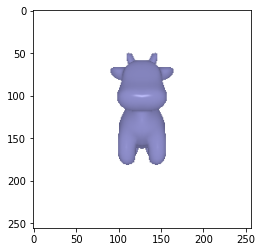

In [51]:
plt.imshow(image)

In [42]:
%pwd

'/content/gdrive/MyDrive/2023Spring/visualize3d'

In [43]:
output_path = "output/single_mesh_render_cow.png"
plt.imsave(output_path, image)

## Render rotating GIF

In [54]:
import imageio
import numpy as np
import pytorch3d
import torch
from PIL import Image, ImageDraw
from tqdm.auto import tqdm
import mcubes

from pytorch3d.ops import cubify
from pytorch3d.io import load_obj


# rotate mesh
def vis_mesh_360(num_frames=20,
                 duration=3,
                 device=None,
                 output_path="output/voxel_test.gif",
                 vertices=None,
                 faces=None,
                 texture=None,
                 image_size=256,
                 R_relative=None,
                 T_relative=None,
                  ):
    
    # Set device
    if device is None:
        # device = get_device()
        if torch.cuda.is_available():
          torch.set_default_tensor_type('torch.cuda.FloatTensor')
        device = get_device()

    # set texture
    if texture != None: # if texture is given, use texture
        texture_rgb = texture.to(device)
        texture = pytorch3d.renderer.TexturesVertex(texture_rgb)
    else: # otherwise set default texture 
        texture_rgb = torch.ones_like(vertices).to(device)
        texture_rgb = texture_rgb * torch.tensor([0.7, 0.7, 1])
        texture = pytorch3d.renderer.TexturesVertex(texture_rgb)

    # set renderer, lights, camera
    renderer = get_mesh_renderer(image_size=image_size, device=device)
    lights = pytorch3d.renderer.PointLights(location=[[0.0, 0.0, -3.0]], device=device)

    R = torch.eye(3).unsqueeze(0)
    T = torch.tensor([[0., 0., 3.]])

    if R_relative != None:
        R = R_relative @ R
    if T_relative != None:
        if R_relative !=None:
            T = R_relative @ T + T_relative
        else: 
            T = T + T_relative

    cameras = pytorch3d.renderer.FoVPerspectiveCameras(
                                                        R=R,
                                                        T=T,
                                                        fov=60,
                                                        device=device,
                                                    )
    
    # Rotate mesh
    rot_angles = torch.linspace(0, 360, num_frames)
    renders = []
    for ang in tqdm(rot_angles):
        rel_rot = pytorch3d.transforms.euler_angles_to_matrix(
                    torch.tensor([0, torch.deg2rad(ang), 0]), "XYZ")
        rot_mesh = pytorch3d.structures.Meshes(
                        verts=vertices.to(device) @ rel_rot.to(device),
                        faces=faces.to(device),
                        textures=texture,).to(device)
        rend = renderer(rot_mesh, cameras=cameras, lights=lights) # (1, N, H, W, 3)
        rend = rend[0, ..., :3].cpu().detach().numpy()  # (N, H, W, 3)
        renders.append(rend)

    # Create gif
    images = []
    for i, r in enumerate(renders):
        image = Image.fromarray((r * 255).astype(np.uint8))
        draw = ImageDraw.Draw(image)
        draw.text((20, 20), f"rotation_angle: {rot_angles[i]:.2f}", fill=(255, 0, 0))
        images.append(np.array(image))
    imageio.mimsave(output_path, images, fps=(num_frames / duration))

In [55]:
verts, faces = get_vf_from_obj("data/cow.obj")
vis_mesh_360(
        vertices = verts,
        faces = faces,
        image_size=256,
        num_frames=20,
        duration=3,
        device=None,
        output_path="output/rotate_mesh_cow.gif",
        texture=None,
        R_relative=None,
        T_relative=None
    )

  0%|          | 0/20 [00:00<?, ?it/s]

# Render Voxel

In [68]:
'''Sample Voxels'''
def sample_voxels():
  # prepare some coordinates
  x, y, z = np.indices((8, 8, 8))

  # draw cuboids in the top left and bottom right corners, and a link between
  # them
  cube1 = (x < 3) & (y < 3) & (z < 3)
  cube2 = (x >= 5) & (y >= 5) & (z >= 5)
  link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

  # combine the objects into a single boolean array
  voxelarray = cube1 | cube2 | link
  voxelarray = torch.from_numpy(voxelarray) # (D, H, W)
  voxelarray = voxelarray.unsqueeze(0)# (N, D, H, W)
  # print(voxelarray.shape)
  return voxelarray

In [69]:
sample_voxels()

torch.Size([1, 8, 8, 8])


tensor([[[[ True,  True,  True, False, False, False, False, False],
          [ True,  True,  True, False, False, False, False, False],
          [ True,  True,  True, False, False, False, False, False],
          [False, False, False, False, False, False, False, False],
          [False, False, False, False, False, False, False, False],
          [False, False, False, False, False, False, False, False],
          [False, False, False, False, False, False, False, False],
          [False, False, False, False, False, False, False, False]],

         [[ True,  True,  True, False, False, False, False, False],
          [ True,  True,  True, False, False, False, False, False],
          [ True,  True,  True, False, False, False, False, False],
          [False, False, False, False, False, False, False, False],
          [False, False, False, False, False, False, False, False],
          [False, False, False, False, False, False, False, False],
          [False, False, False, False, False, 

In [74]:
'''
Visualize Voxels
voxels: A FloatTensor of shape (N, D, H, W) containing occupancy probabilities.
https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/ops/cubify.html

'''
def vis_voxel_360(
        voxels, # tensor (size, size, size)
        voxel_size=32,
        image_size=256,
        num_frames=20,
        duration=3,
        device=None,
        output_path='output/rotate_voxel_cubes.gif',
        R_relative=None,
        T_relative=None,
):
    if device is None:
        # device = get_device()
        if torch.cuda.is_available():
          torch.set_default_tensor_type('torch.cuda.FloatTensor')
        device = get_device()

    # Converts voxels in to mesh
    voxels = voxels.to(device)
    mesh = cubify(voxels, thresh=0.8).to(device)
    vertices, faces = mesh.verts_list()[0].unsqueeze(0), mesh.faces_list()[0].unsqueeze(0)

    vis_mesh_360(num_frames=num_frames, 
                 duration=duration,
                 device=device,
                 output_path=output_path,
                 vertices=vertices,
                 faces = faces,
                 image_size=image_size,
                 R_relative=R_relative,
                 T_relative=T_relative)

In [75]:
voxels = sample_voxels()
vis_voxel_360(voxels)

torch.Size([1, 8, 8, 8])


  0%|          | 0/20 [00:00<?, ?it/s]